In [23]:
#XVFB will be launched if you run on a server
import os
!bash ../xvfb start
%env DISPLAY=:1

Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


In [24]:
import numpy as np
from sklearn.neural_network import MLPClassifier
#from joblib import Parallel, delayed

In [25]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    n = len(states_batch)
    
    elite_actions = []
    elite_states  = []
    for i in range(n):
        if rewards_batch[i] > reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i]) 
    
    return elite_states, elite_actions

In [26]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    if reward_range[0] > reward_range[1]:
        tmp = reward_range[0]
        reward_range[0] = reward_range[1]
        reward_range[1] = tmp
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [27]:
def generate_session_mountain_car(t_max=10000):
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    div = 1
    #if t < 10:
    #    div = 5
    #elif t < 20:
    #    div = 2
    
    for t in range(t_max):
        
        # a vector of action probabilities in current state
        probs = agent.predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p=probs.ravel())
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: 
            total_reward /= div
            break
    return states, actions, total_reward

In [28]:
import gym

env = gym.make("MountainCar-v0").env

In [29]:
actions = {'left': 0, 'stop': 1, 'right': 2}
n_actions = len(actions)

In [30]:
# create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(
    hidden_layer_sizes=(40,10),
    learning_rate='invscaling',
    learning_rate_init=0.01,
    power_t=0.2,
    activation='tanh',
    warm_start=True,  # keep progress between .fit() calls
    max_iter=1,       # make only 1 iteration on each .fit()
)

# initialize agent to the dimension of state and number of actions
agent.fit([env.reset()]*n_actions, list(range(n_actions)));

env.reset()

/home/julia-trofim/.local/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array([-0.44883772,  0.        ])

In [31]:
from joblib import Parallel, delayed

In [32]:
np.random.seed(67)

mean reward = -113.490, threshold=-106.000


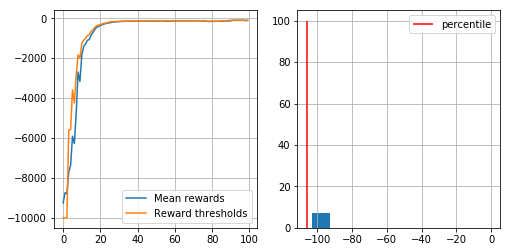

In [33]:
n_sessions = 100
percentile = 70
log = []

for t in range(100):
    #generate new sessions
    sessions = Parallel(n_jobs=40)(
        delayed(generate_session_mountain_car)() for _ in range(n_sessions)
    )
    
    batch_states,batch_actions,batch_rewards = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(batch_states,batch_actions,batch_rewards,percentile)

    if len(elite_states):
        agent.fit(elite_states, elite_actions)
        
    show_progress(batch_rewards, log, percentile, reward_range=[0,np.max(batch_rewards)])


In [34]:
import matplotlib.pyplot as plt

from IPython import display

<IPython.core.display.Javascript object>


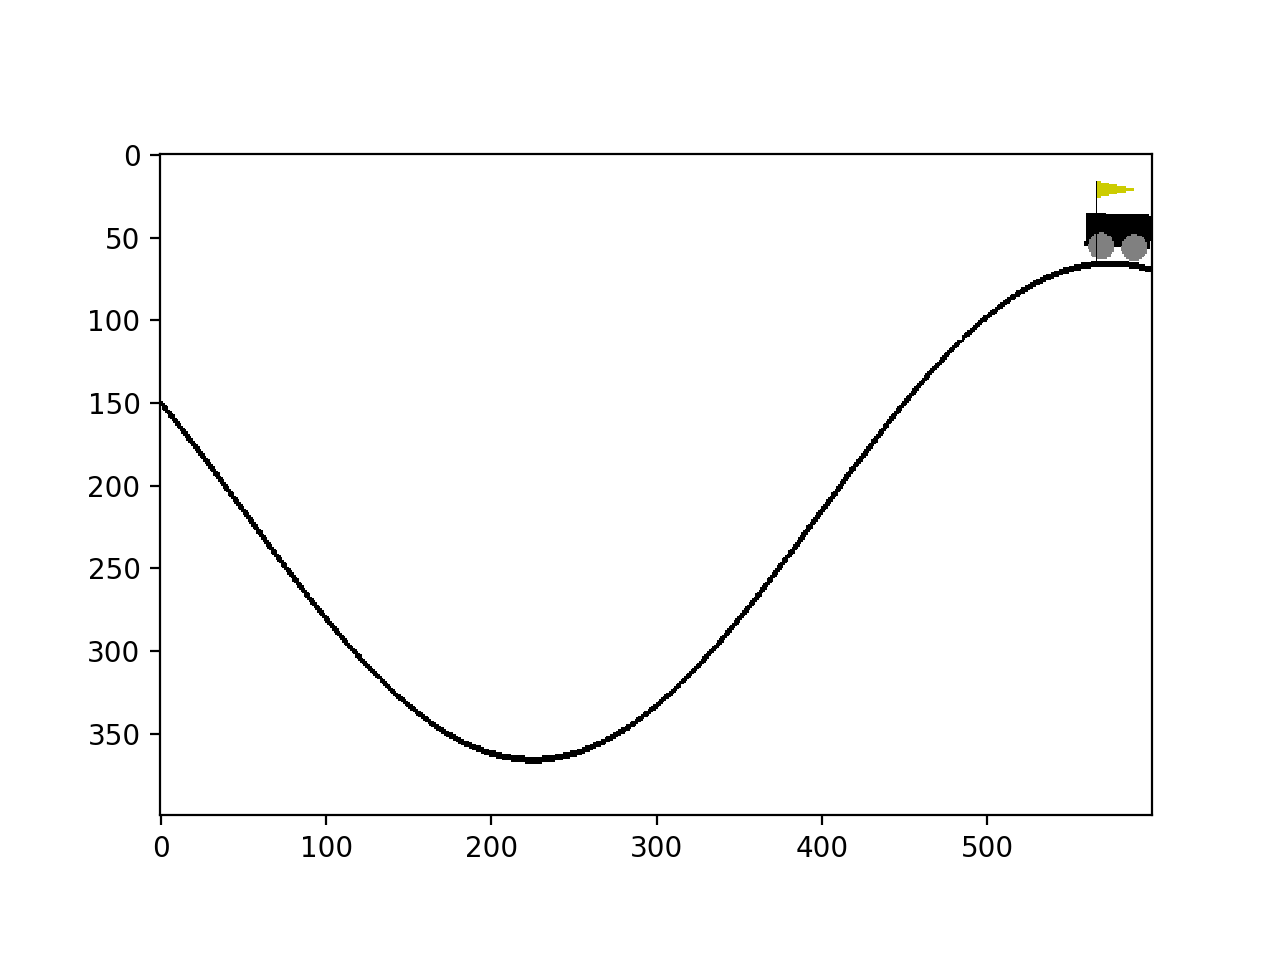

[0.5368578  0.04995707]
109
Well done!


In [35]:
import gym
import matplotlib.pyplot as plt

env = gym.make("MountainCar-v0").env
TIME_LIMIT = 250
env.max_episode_steps = TIME_LIMIT + 1
s = env.reset()

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for t in range(TIME_LIMIT):
    a = np.argmax(agent.predict_proba([s])[0])
    s, r, done, _ = env.step(a)
    
    #draw game image on display
    ax.clear()
    ax.imshow(env.render('rgb_array'))
    fig.canvas.draw()
    
    if done:
        print(s)
        print(t)
        print("Well done!")
        break
else:    
    print("Time limit exceeded. Try again.")